In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
# hyper-parameters
BATCH_SIZE = 128
LR = 0.01
GAMMA = 0.90
EPISILO = 0.9
MEMORY_CAPACITY = 2000
Q_NETWORK_ITERATION = 100

env = gym.make("CartPole-v1")
env = env.unwrapped
NUM_ACTIONS = env.action_space.n
NUM_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample.shape

In [5]:
class Net(nn.Module):
    """docstring for Net"""
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 50)
        self.fc1.weight.data.normal_(0,0.1)
        self.fc2 = nn.Linear(50,30)
        self.fc2.weight.data.normal_(0,0.1)
        self.out = nn.Linear(30,NUM_ACTIONS)
        self.out.weight.data.normal_(0,0.1)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        action_prob = self.out(x)
        return action_prob

class DQN():
    """docstring for DQN"""
    def __init__(self):
        super(DQN, self).__init__()
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        # why the NUM_STATE*2 +2
        # When we store the memory, we put the state, action, reward and next_state in the memory
        # here reward and action is a number, state is a ndarray
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0) # get a 1D array
        if np.random.randn() <= EPISILO:# greedy policy
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        else: # random policy
            action = np.random.randint(0,NUM_ACTIONS)
            action = action if ENV_A_SHAPE ==0 else action.reshape(ENV_A_SHAPE)
        return action


    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1


    def learn(self):
        #update the parameters
        if self.learn_step_counter % Q_NETWORK_ITERATION ==0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter+=1

        #sample batch from memory
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1:NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:,-NUM_STATES:])

        #q_eval
        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

def reward_func(env, x, x_dot, theta, theta_dot):
    r1 = (env.x_threshold - abs(x))/env.x_threshold - 0.5
    r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
    reward = r1 + r2
    return reward

  0%|          | 0/400 [00:00<?, ?it/s]/home/alghra0e/rl/env/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
/home/alghra0e/rl/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alghra0e/rl/env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|█         | 42/400 [00:00<00:01, 213.38it/s, steps: 9, reward: 5.503970262686964, loss ]  

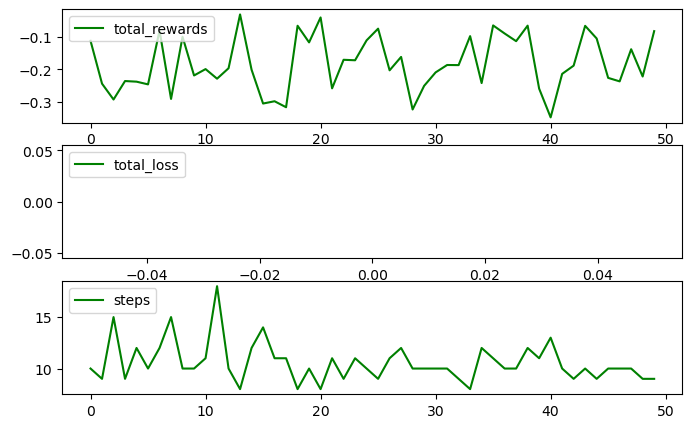

 22%|██▏       | 89/400 [00:00<00:02, 130.81it/s, steps: 13, reward: 7.138997561281137, loss ] 

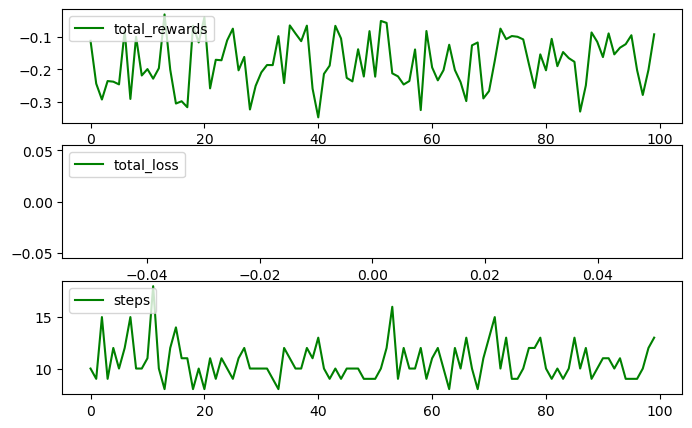

 34%|███▍      | 135/400 [00:01<00:02, 124.68it/s, steps: 10, reward: 5.924287942379594, loss ] 

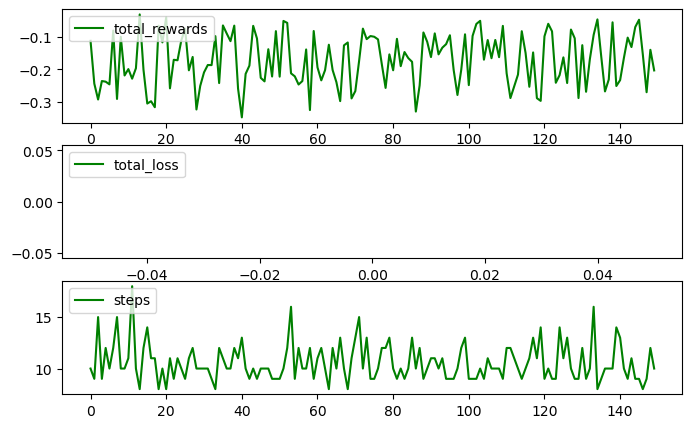

 46%|████▌     | 183/400 [00:01<00:01, 127.47it/s, steps: 71, reward: 36.03220752691377, loss 0.009909019884194287] 

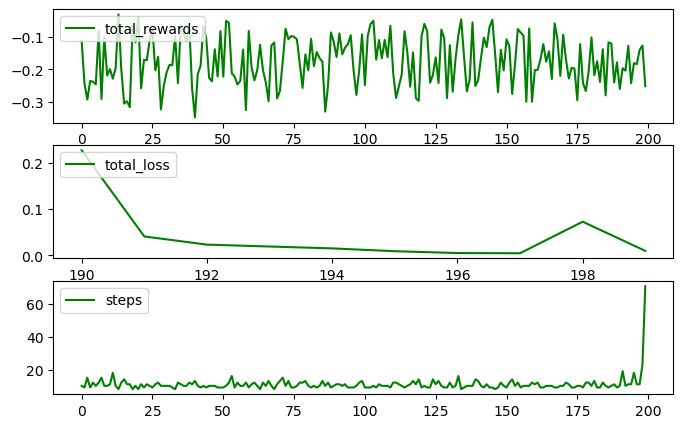

 62%|██████▏   | 248/400 [01:05<03:04,  1.21s/it, steps: 688, reward: 495.29099727541467, loss 0.0013992858670420435] 

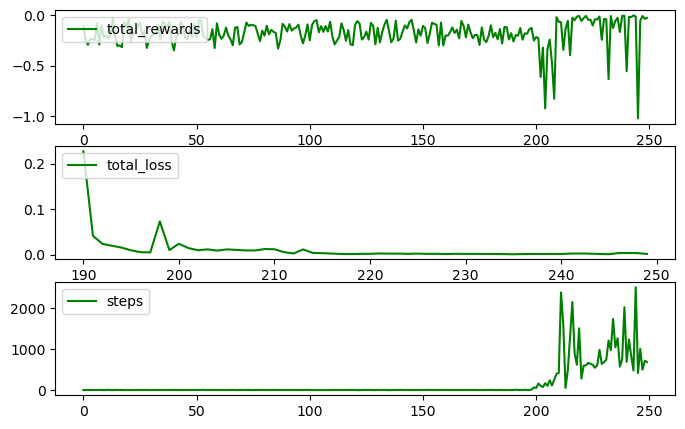

 75%|███████▍  | 299/400 [02:31<02:43,  1.62s/it, steps: 802, reward: 579.9471115417409, loss 0.0005688055882677773]  

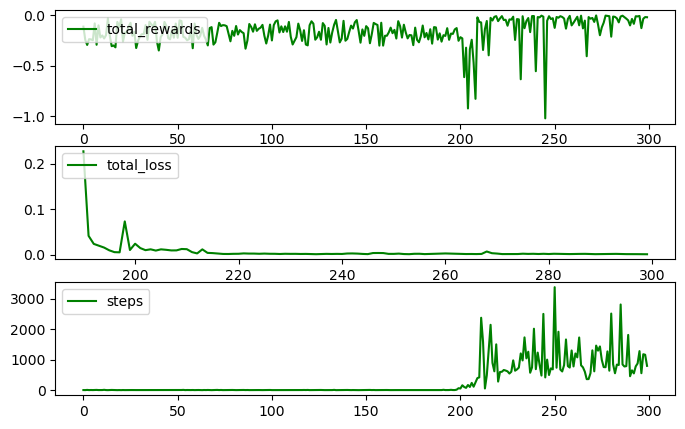

 87%|████████▋ | 349/400 [04:05<02:39,  3.12s/it, steps: 1315, reward: 965.5343563534908, loss 0.0007718903992033808] 

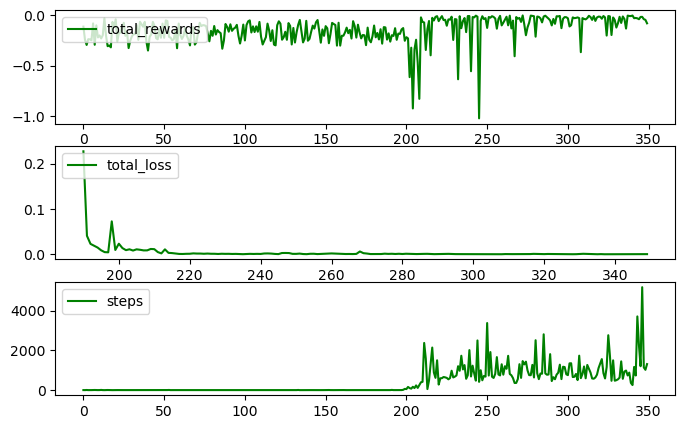

100%|█████████▉| 398/400 [05:45<00:05,  2.63s/it, steps: 281, reward: 163.10474729064526, loss 0.005215948178504139]   

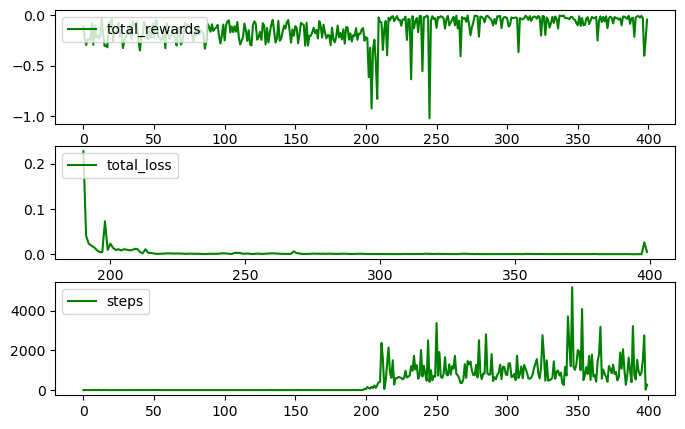

100%|██████████| 400/400 [05:45<00:00,  1.16it/s, steps: 281, reward: 163.10474729064526, loss 0.005215948178504139]


In [6]:
dqn = DQN()
episodes = 400
print("Collecting Experience....")
reward_list = []
step_list = []
loss_list = []        
pbar = tqdm(range(episodes))

for i in pbar:
    state, _ = env.reset()
    ep_reward = 0
    loss = []
    steps = 0
    while True:
        env.render()
        action = dqn.choose_action(state)
        next_state, _ , done, _, info = env.step(action)
        x, x_dot, theta, theta_dot = next_state
        reward = reward_func(env, x, x_dot, theta, theta_dot)

        dqn.store_transition(state, action, reward, next_state)
        ep_reward += reward
        steps += 1
        if dqn.memory_counter >= MEMORY_CAPACITY:
            loss.append(dqn.learn())
            # if done:
            #     print("episode: {} , the episode reward is {}".format(i, round(ep_reward, 3)))
        if done:
            break
        state = next_state
    r = copy.copy(reward)
    reward_list.append(r)
    step_list.append(steps)
    loss_list.append(np.mean(loss))
    pbar.set_postfix_str(f"steps: {steps}, reward: {ep_reward}, loss {np.mean(loss) if loss else ''}")

    if (i+1) % 50 == 0 or i == episodes:
        fig, ax = plt.subplots(3, figsize=(8, 5))
        ax[0].plot(reward_list, 'g-', label='total_rewards')
        ax[0].legend(loc="upper left")
        ax[1].plot(loss_list, 'g-', label='total_loss')
        ax[1].legend(loc="upper left")
        ax[2].plot(step_list, 'g-', label='steps')
        ax[2].legend(loc="upper left")
        plt.show()